# Data Extraction       

**Note: For educational/tutorial purposes, I have left in place the details of an approach that didnt work. This is how most of the real life data science problems are. I wanted to protect the originality of the workflow in this tutorial.**

## Details   

**The primary goal of this tutorial is to showcase that we can use biobert embeddings as features, in addition to other features to train a machine learning algorithm. Traditionally, features have been thought to be data in a column that is not free form text. With the advent of language models, we understand that the embeddings are representational learning of free form text and that embeddings(or vectors) provide us structure for free form text that didn't exist before. My goal is to showcase how to use this in combination with traditional AI/ML methodlogy to train a deep neural network.** 

The goal of this project is to predict the probability that a given hospitalized patient will be hospitalized again in 30 days, 60 days, and 90 days. Again, while this is the same readmission process, the novelty lies in the approach that I have taken to solve this problem. One of the most important identifiers is the `subject_id` which is contained in the table `patients` within the hospital schema. It is a good starting point for any type of data analysis project. Let us understand the basics of this dataset.   
The tables that we will use are:   
1. patients.csv   
2. admissions.csv  
3. diagnoses_icd.csv   
4. d_code-diagnoses.csv     

In [1]:
# Load the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Patient dataset  

In [ ]:
patients_raw = pd.read_csv('../data/raw/patients.csv.gz', 
                           compression='gzip', 
                           dtype={'subject_id': str,
                                  'gender': str})

print(patients_raw.info())
print(patients_raw.head())
print(patients_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  object
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(2), object(4)
memory usage: 16.7+ MB
None
  subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0   10000032      F          52         2180       2014 - 2016  2180-09-09
1   10000048      F          23         2126       2008 - 2010         NaN
2   10000058      F          33         2168       2020 - 2022         NaN
3   10000068      F          19         2160       2008 - 2010         NaN
4   10000084      M          72         2160       2017 - 2019  2161-02-13


The subject_id is the key identifier across all the tables. Since this is a large dataset, we need to work on a sample of data to be able to build our machine learning model. There are multiple ways to select a sample. Let us understand the distribution of `gender`, `anchor_year_group`, `anchor_age`, and `dod` distribution to strategize our sample selection. `dod` is a date, so it might be best to create a new column `death_flag` which will be binary, to recognize if a given subject is dead.      

In [3]:
# Create a binary “death flag”
patients_raw['death_flag'] = patients_raw['dod'].notna().map({True: 'Died', False: 'Survived'})

# Understanding the death_flag by gender
ct_counts = pd.crosstab(
    patients_raw['gender'],
    patients_raw['death_flag'],
    margins=True,
    margins_name='Total'
)
print("Counts:\n", ct_counts, "\n")

Counts:
 death_flag   Died  Survived   Total
gender                             
F           18114    173870  191984
M           20187    152456  172643
Total       38301    326326  364627 



This is a pretty even split. So when we select a random sample, it is likely that `gender` and `death_flag` should be representative of the gender and survival. Let us also understand the split of  `anchor_age_group`. 

Text(0.5, 1.0, 'Anchor Year Group')

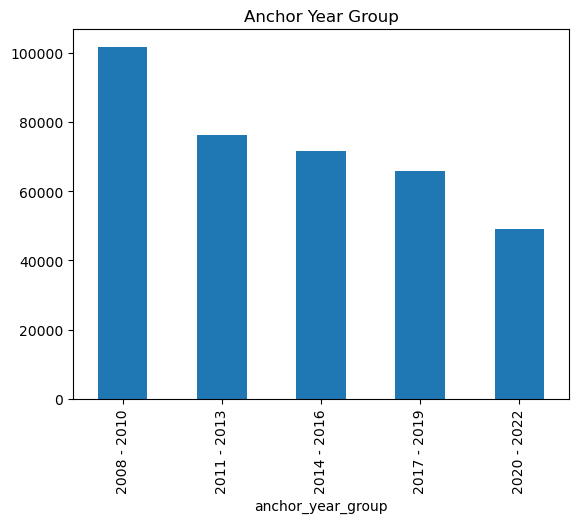

In [4]:
group_counts = patients_raw['anchor_year_group'].value_counts()
group_counts.plot(kind='bar').set_title('Anchor Year Group')

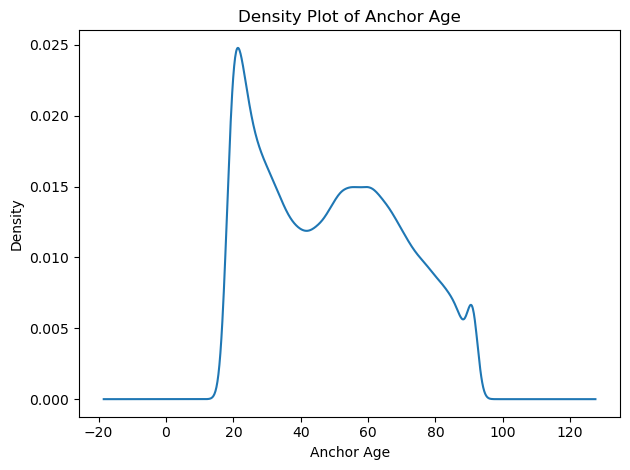

In [6]:
# Density plot of anchor_age
patients_raw['anchor_age'].plot(kind='density')
plt.xlabel('Anchor Age')
plt.title('Density Plot of Anchor Age')
plt.tight_layout()
plt.show()

Based on the density plot, it may be best to keep the cohort to anchor_age 20 to 80. 

#### Cohort Selection Criteria   

1. Random sample of 25,000 subject_id s(Since this is a large enough sample, stratification is not required).   
2. Age at least 20 and at most 80.   

**The next few steps didnt work as expected so I had to devise a new plan on the go. If you would rather get to the point that which worked directly, please go to section:**

In [ ]:
# Select ages 20 to 80 and random sample of 25,000 subject_id s
patients_sel = patients_raw[(patients_raw['anchor_age'] >= 20) & (patients_raw['anchor_age'] <= 80)]
patients_sel = patients_sel.sample(n=25000, random_state=46)

# Save the selected patients to a new CSV file
patients_sel.to_csv('../data/processed/patients_selected.csv', 
                    index=False)

# Remove the original patients file from memory
del patients_raw

### Admissions dataset      
Let us select the demographics of the selected cohort.   

In [ ]:
# Let us store the subject_id of the selected cohort in a list so we can readily apply this filter
subject_id_list = patients_sel['subject_id'].tolist()

# Since the admissions table contains the ethinicity and insurance information, we will filter the admissions table to only include the subject_id in the list
admissions_raw = pd.read_csv('../data/raw/admissions.csv.gz', 
                            compression='gzip', 
                            dtype={'subject_id': str,
                                   'race': str,
                                   'marital_status': str,
                                   'insurance': str,
                                   'admission_type': str,
                                   'admission_location': str,
                                   'discharge_location': str})[['subject_id', 'race', 'marital_status', 'insurance', 'admission_type', 'admission_location', 'discharge_location']]

admissions_sel = admissions_raw[admissions_raw['subject_id'].isin(subject_id_list)]
 # Write the selected admissions to a new CSV file
admissions_sel.to_csv('../data/processed/admissions_selected.csv', index=False)

# Remove the original admissions file from memory
del admissions_raw

print(admissions_sel.info())
# Let us understand the race and insurance distribution of the selected cohort
print(admissions_sel.groupby('race').size())
print(admissions_sel.groupby('insurance').size())

<class 'pandas.core.frame.DataFrame'>
Index: 36393 entries, 13 to 545948
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject_id          36393 non-null  object
 1   race                36393 non-null  object
 2   marital_status      35527 non-null  object
 3   insurance           35744 non-null  object
 4   admission_type      36393 non-null  object
 5   admission_location  36393 non-null  object
 6   discharge_location  26371 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB
None
race
AMERICAN INDIAN/ALASKA NATIVE                   92
ASIAN                                          570
ASIAN - ASIAN INDIAN                           107
ASIAN - CHINESE                                537
ASIAN - KOREAN                                  37
ASIAN - SOUTH EAST ASIAN                       136
BLACK/AFRICAN                                  222
BLACK/AFRICAN AMERICAN                        5099
BLACK

Clearly, there are a lot of columns and the groups that are too granular for the analysis that we are going to do. It may be best to collapse them into fewer representative group. There are many categories and for the sake of generalization and simplicity, let's collapse the `race` to BLACK_ALL, HISPANIC_ALL, ASIAN_ALL, WHITE_ALL, OTHERS and NATIVE. 

In [ ]:
# Lets create a modified race column called race_mod
admissions_sel['race_mod'] = admissions_sel['race']

In [ ]:
import pandas as pd
import numpy as np

# assume your DataFrame is called df

# define the conditions (order matters: “BLACK” before “BLACK/CAPE…” both match the first)
conds = [
    admissions_sel['race_mod'].str.contains('BLACK', case=False, na=False),
    admissions_sel['race_mod'].str.contains('WHITE', case=False, na=False),
    admissions_sel['race_mod'].str.contains('ASIAN', case=False, na=False),
    admissions_sel['race_mod'].str.contains('HISPANIC', case=False, na=False),
    # any of these substrings → native
    admissions_sel['race_mod'].str.contains('AMERICAN INDIAN|ALASKA NATIVE|HAWAIIAN|PACIFIC ISLANDER',
                               case=False, na=False),
]

# the new group names
choices = [
    'BLACK',
    'WHITE',
    'ASIAN',
    'HISPANIC',
    'NATIVE',
]

# collapse into a new column
admissions_sel['race_group'] = np.select(conds, choices, default='OTHER_ALL')

# make it a categorical for memory & modeling
admissions_sel['race_group'] = admissions_sel['race_group'].astype('category')

# check your work
print(admissions_sel['race_group'].value_counts())


race_group
WHITE        23710
BLACK         6002
OTHER_ALL     2970
HISPANIC      2211
ASIAN         1387
NATIVE         113
Name: count, dtype: int64


This information is very revealing. We are likely to have class imbalance situation as the Whites are over represented in the cohort. However, we do not have the race information in the patients table. Due to this, our approach didnt work well. Let us revise our strategy to select the subject_ids that will help us overcome this challenge. One approach will be to take just the subject_id and race column from the admissions table as the starting point instead of the patients table. Then get just the unique values and remove any duplicated subject_id. Use an even representation of races from this dataset to go back to patients table for selection.   

Let us start fresh, but this time from admissions table:   

In [ ]:
# select only the subject_id and race from admissions_raw table. Remove the duplicates.
admissions_raw = pd.read_csv('../data/raw/admissions.csv.gz', 
                            compression='gzip', 
                            dtype={'subject_id': str,
                                   'race': str})

admissions_raw = admissions_raw[['subject_id', 'race']].drop_duplicates()

print(admissions_raw['race'].value_counts())

race
WHITE                                        141525
BLACK/AFRICAN AMERICAN                        24014
UNKNOWN                                       11749
OTHER                                         11683
WHITE - OTHER EUROPEAN                         6626
ASIAN                                          4620
HISPANIC OR LATINO                             4163
HISPANIC/LATINO - PUERTO RICAN                 3905
ASIAN - CHINESE                                3542
UNABLE TO OBTAIN                               2997
HISPANIC/LATINO - DOMINICAN                    2549
BLACK/CAPE VERDEAN                             2409
WHITE - RUSSIAN                                2331
BLACK/CARIBBEAN ISLAND                         1623
BLACK/AFRICAN                                  1618
PATIENT DECLINED TO ANSWER                     1554
ASIAN - SOUTH EAST ASIAN                        887
ASIAN - ASIAN INDIAN                            841
WHITE - EASTERN EUROPEAN                        826
HISPANI

In [ ]:
# define the conditions (order matters: “BLACK” before “BLACK/CAPE…” both match the first)
conds = [
    admissions_raw['race'].str.contains('BLACK', case=False, na=False),
    admissions_raw['race'].str.contains('WHITE', case=False, na=False),
    admissions_raw['race'].str.contains('ASIAN', case=False, na=False),
    admissions_raw['race'].str.contains('HISPANIC', case=False, na=False),
    # any of these substrings → native
    admissions_raw['race'].str.contains('AMERICAN INDIAN|ALASKA NATIVE|HAWAIIAN|PACIFIC ISLANDER',
                               case=False, na=False),
]

# the new group names
choices = [
    'BLACK',
    'WHITE',
    'ASIAN',
    'HISPANIC',
    'NATIVE',
]

# collapse into a new column
admissions_raw['race_group'] = np.select(conds, choices, default='OTHER_ALL')

# make it a categorical for memory & modeling
admissions_raw['race_group'] = admissions_raw['race_group'].astype('category')

# check your work
print(admissions_raw['race_group'].value_counts())

race_group
WHITE        152053
BLACK         29664
OTHER_ALL     29480
HISPANIC      13684
ASIAN         10239
NATIVE          814
Name: count, dtype: int64


So except for 'NATIVE', we have a decent sample across all the other races. So we will keep all the 'NATIVE' category and keep exactly 5000 subject_ids from the rest. And then we will repeat the process as before. We do not have to do any further stratification for the purposes of this tutorial as we have already verified the data distribution in the patients table.    

In [ ]:
# Randomly select 5000 WHITE, 5000 BLACK, 5000 ASIAN, 5000 HISPANIC, 5000 NATIVE from the admissions_raw table
# with values exactly: 'WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_ALL', 'NATIVE'

to_sample = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER_ALL']
subsamples = []

# sample 5000 from each of the big groups
for grp in to_sample:
    grp_df = admissions_raw[admissions_raw['race_group'] == grp]
    # sanity check
    if len(grp_df) < 5000:
        raise ValueError(f"Not enough records in group {grp} (only {len(grp_df)})")
    subsamples.append(
        grp_df.sample(n=5000, random_state=46)
    )

# append the entire NATIVE group
native_df = admissions_raw[admissions_raw['race_group'] == 'NATIVE']
subsamples.append(native_df)

# concatenate and shuffle
sample_df = pd.concat(subsamples, axis=0).reset_index(drop=True)

# check your new counts
print(sample_df['race_group'].value_counts())

# write the selected patients to a new CSV file
sample_df.to_csv('../data/processed/patients_selected.csv', index=False)


race_group
ASIAN        5000
BLACK        5000
HISPANIC     5000
OTHER_ALL    5000
WHITE        5000
NATIVE        814
Name: count, dtype: int64


This looks good! Now lets collects the subject_id s and redo the patients file and the admissions file. And we will promptly remove the large files so that we have sufficient memory to train the machine learning algorithm. 

In [ ]:
sample_df = pd.read_csv('../data/processed/patients_selected.csv',
                        dtype={'subject_id': str})

# Let us store the subject_id of the selected cohort in a list so we can readily apply this filter
subject_id_list = sample_df['subject_id'].tolist()

In [ ]:
# Let us store the subject_id of the selected cohort in a list so we can readily apply this filter
subject_id_list = sample_df['subject_id'].tolist()
admissions_raw = pd.read_csv('../data/raw/admissions.csv.gz', 
                            compression='gzip', 
                            dtype={'subject_id': str,
                                   'race': str,
                                   'marital_status': str,
                                   'insurance': str,
                                   'admission_type': str,
                                   'admission_location': str,
                                   'discharge_location': str})


admissions_sel = admissions_raw[admissions_raw['subject_id'].isin(subject_id_list)]
admissions_sel.to_csv('../data/processed/admissions_selected.csv', 
                      index=False)

print(admissions_sel.info())

# Since the admissions table contains the ethinicity and insurance information, we will filter the admissions table to only include the subject_id in the list

patients_raw = pd.read_csv('../data/raw/patients.csv.gz', 
                            compression='gzip', 
                            dtype={'subject_id': str,
                                   'gender': str})
patients_raw['death_flag'] = patients_raw['dod'].notna().map({True: 'Died', False: 'Survived'})
patients_sel = patients_raw[patients_raw['subject_id'].isin(subject_id_list)]
patients_sel.to_csv('../data/processed/patients_selected.csv', 
                    index=False)
print(patients_sel.info())
del patients_raw, admissions_raw, sample_df

<class 'pandas.core.frame.DataFrame'>
Index: 67025 entries, 21 to 545934
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            67025 non-null  object
 1   hadm_id               67025 non-null  int64 
 2   admittime             67025 non-null  object
 3   dischtime             67025 non-null  object
 4   deathtime             1387 non-null   object
 5   admission_type        67025 non-null  object
 6   admit_provider_id     67025 non-null  object
 7   admission_location    67025 non-null  object
 8   discharge_location    47014 non-null  object
 9   insurance             65671 non-null  object
 10  language              66933 non-null  object
 11  marital_status        64755 non-null  object
 12  race                  67025 non-null  object
 13  edregtime             46937 non-null  object
 14  edouttime             46937 non-null  object
 15  hospital_expire_flag  67025 non-null  i

Awesome! Things are looking good so far. Let's move on to our next table. 

### Diagnoses table  

For every hospital admission, there is a subject_id and a hadm_id. There is also a seq_num whch lists all the diagnoses that were made during the visit. These diagnoses are given as codes which can be decoded with another table, d_icd_diagnoses. Our strategy for extracting data out of this table will be as follows:   

1. Extract all the data from diagnoses_icd table where the subject_id is in our selected list.  
2. Merge the d_icd_diagnoses table with the icd_code column of the dimension table.   
3. Collapse the long_title of each subject_id and hadm_id combination, so that we could use create a free form text column that can be vectorized to serve as a feature.   
4. This will be our diagnoses_sel table(without vectorizing yet)    

In [ ]:
diagnoses_icd_raw = pd.read_csv('../data/raw/diagnoses_icd.csv.gz', 
                                compression='gzip', 
                                dtype={'subject_id': str,
                                       'hadm_id': str,
                                       'icd_code': str,
                                       'seq_num': int})

diagnoses_icd_sel = diagnoses_icd_raw[diagnoses_icd_raw['subject_id'].isin(subject_id_list)]

del diagnoses_icd_raw

print(diagnoses_icd_sel.info())
print(diagnoses_icd_sel.head())

<class 'pandas.core.frame.DataFrame'>
Index: 750774 entries, 168 to 6363530
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject_id   750774 non-null  object
 1   hadm_id      750774 non-null  object
 2   seq_num      750774 non-null  int64 
 3   icd_code     750774 non-null  object
 4   icd_version  750774 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 34.4+ MB
None
    subject_id   hadm_id  seq_num icd_code  icd_version
168   10000764  27897940        1     8020            9
169   10000764  27897940        2    41071            9
170   10000764  27897940        3     5849            9
171   10000764  27897940        4     2875            9
172   10000764  27897940        5     7802            9


In [ ]:
# Let us extract the dimension table for the diagnoses_icd table
d_icd_codes = pd.read_csv('../data/raw/d_icd_diagnoses.csv.gz',
                          compression='gzip',
                          dtype={'icd_code': str,
                                 'long_title': str})

print(d_icd_codes.info())
print(d_icd_codes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112107 entries, 0 to 112106
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     112107 non-null  object
 1   icd_version  112107 non-null  int64 
 2   long_title   112107 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB
None
  icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified
3     0020            9                          Typhoid fever
4     0021            9                    Paratyphoid fever A


**Quick checkpoint:** So far our strategy seems to be working. Let us move on to merge them and process them further.  

In [ ]:
# arrange the diagnoses_icd table by subject_id, hadm_id and seq_num
diagnoses_icd_sel = diagnoses_icd_sel.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])

# Merge the diagnoses_icd_sel table with the d_icd_codes table on the icd_code column
diagnoses_icd_sel = diagnoses_icd_sel.merge(d_icd_codes, 
                                            on='icd_code', 
                                            how='left', 
                                            suffixes=('', '_dup'))

diagnoses_icd_sel = diagnoses_icd_sel.drop([col for col in diagnoses_icd_sel.columns if col.endswith('_dup')], axis=1)

print(diagnoses_icd_sel.info())
print(diagnoses_icd_sel.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764575 entries, 0 to 764574
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject_id   764575 non-null  object
 1   hadm_id      764575 non-null  object
 2   seq_num      764575 non-null  int64 
 3   icd_code     764575 non-null  object
 4   icd_version  764575 non-null  int64 
 5   long_title   764575 non-null  object
dtypes: int64(2), object(4)
memory usage: 35.0+ MB
None
  subject_id   hadm_id  seq_num icd_code  icd_version  \
0   10000764  27897940        1     8020            9   
1   10000764  27897940        2    41071            9   
2   10000764  27897940        3     5849            9   
3   10000764  27897940        4     2875            9   
4   10000764  27897940        5     7802            9   

                                          long_title  
0                     Closed fracture of nasal bones  
1  Subendocardial infarction, initial episode

We managed to successfully combine the tables. The next step is to collapse the icd descriptions for each subject_id and hadm_id combination.   

In [ ]:
# Now lets collapse the long_title column into a single string for each subject_id and hadm_id combination
diagnoses_icd_sel['long_title'] = diagnoses_icd_sel['long_title'].fillna('')

diagnoses_icd_sel = diagnoses_icd_sel.groupby(['subject_id', 'hadm_id']).agg({'long_title': ' '.join}).reset_index()

diagnoses_icd_sel.to_csv('../data/processed/diagnoses_icd_sel.csv', index=False)

print(diagnoses_icd_sel.info())
print(diagnoses_icd_sel.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66963 entries, 0 to 66962
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  66963 non-null  object
 1   hadm_id     66963 non-null  object
 2   long_title  66963 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
  subject_id   hadm_id                                         long_title
0   10000764  27897940  Closed fracture of nasal bones Subendocardial ...
1   10000980  20897796  Hypertensive heart and chronic kidney disease ...
2   10000980  24947999  Acute on chronic systolic heart failure Chroni...
3   10000980  25242409  Acute venous embolism and thrombosis of deep v...
4   10000980  25911675  Iron deficiency anemia secondary to blood loss...


Perfect! We got the table we needed.   
    
**A quick recap: What did we achieve so far?**   
    
So far we have managed to complete the following:   
1. A sample of the patient list that is a class balanced for race, and gender.  
2. The demographics of the patient list.   
3. Admissions history of the patient.   
4. ICD diagnoses of each of those admissions.   

Here are the files that we have created that we will use for feature engineering:   

1. diagnoses_icd_sel: '/data/processed/diagnoses_icd_sel.csv'    
2. admissions_sel: /data/processed/admissions_selected.csv'   
3. patients_sel: /data/processed/patients_selected.csv'    

And the above files contain the following information:   

1. Demograhics - including age, gender, race  
2. Insurance details   
3. Admission details  
4. Discharge details(including if the patient died during the stay)   
5. List of all the diagnoses.   

**Whats next?** Feature engineering so that we have data for input, and output to train the machine learning algorithm.  